<a href="https://colab.research.google.com/github/mdpatel2/MSAAI-521/blob/main/MSAAI_521_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [1]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [3]:
#!pwd

/content/drive/MyDrive/kaggle


In [4]:
#!ls

kaggle.json


In [5]:
#!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [03:54<00:00, 24.8MB/s]
100% 5.30G/5.30G [03:54<00:00, 24.3MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

%%html
# Inspect the data

&#10004; How many categories are there? 
* How many images are there?
* How many images in each category?
* Are there any duplicates?
* What is the size of the images? 



In [3]:
%cd ..

/content/drive/MyDrive


In [ ]:
import pathlib

data_url = "kaggle/images"
data_dir = pathlib.Path(data_url)
img_paths = list(data_dir.glob('*/*.jpg'))
img_count = len(img_paths)

In [9]:
print(f"Images: {img_count:,} First Path: {img_paths[0]}")

Images: 101,000 First Path: kaggle/images/apple_pie/1200079.jpg


In [14]:
import pandas as pd

In [17]:
classes = pd.read_csv('/content/drive/MyDrive/kaggle/meta/meta/classes.txt', columns=['class'])

TypeError: ignored

In [16]:
classes.head()

,apple_pie
0,baby_back_ribs
1,baklava
2,beef_carpaccio
3,beef_tartare
4,beet_salad


In [20]:
 import matplotlib.pyplot as plt

TypeError: ignored

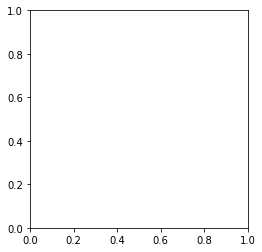

In [22]:
plt.imshow(img_paths[0])

# Look inspect the data

1.  Inspect the data
2.  Create classification model
3.  Do something interesting




In [ ]:
mnist = keras.Sequential([
    # images are 28x28 with one color channel
    layers.Input(shape =(28, 28, 1)),
    # two convolutional layers with 32 filters
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # max pooling / dimensional reduction
    layers.MaxPooling2D((2, 2)),
    # two convolutional layers with 64 filters
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # pooling is usually 2x2 with a stride of 2, thus (2,2)
    layers.MaxPooling2D((2, 2)),
    # flatten. the input to the neural network should be 1D
    layers.Flatten(),
    # fully connected network
    ## hidden layer with 512 nodes
    layers.Dense(512, activation='relu'),
    ## output layer. one neuron for each digit 0-9
    layers.Dense(10)
    ])

keras.utils.plot_model(mnist, show_shapes=True)